## Interpretable Predictive modelling

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('Haberman_Breast_cancer_operation.csv')
print(data.shape)
data.head()

(306, 4)


,Age,Year,Axillary nodes,Survival status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [3]:
data['Survival status'].value_counts()/len(data)

1    0.735294
2    0.264706
Name: Survival status, dtype: float64

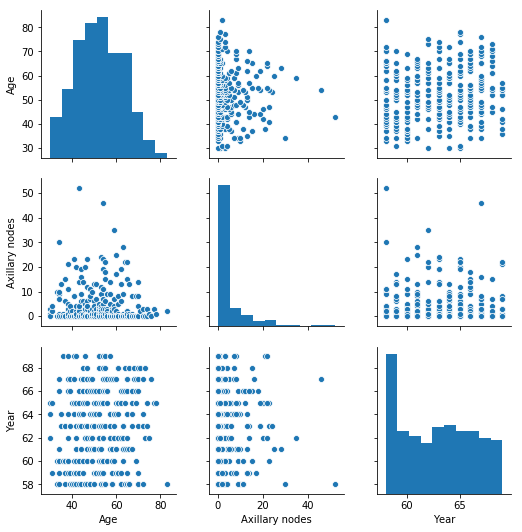

In [4]:
%matplotlib inline

sns.pairplot(data[data.columns.difference(['Survival status'])])

In [5]:
data[data.columns.difference(['Survival status'])].corr()

,Age,Axillary nodes,Year
Age,1.000000,-0.063176,0.089529
Axillary nodes,-0.063176,1.000000,-0.003764
Year,0.089529,-0.003764,1.000000


There seems no multicollinearity in the data

From our data analysis there seemed to be not a strong relationship between Year and Survival status, hence we will drop it for now

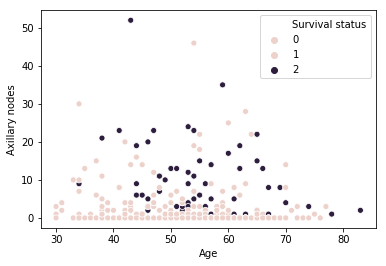

In [6]:
sns.scatterplot('Age','Axillary nodes', hue = 'Survival status', data=data)

The data does not seem to be linearly separable, but may be the extra dimension of Year may help separate it. We will find that out later.

In [7]:
X = data[data.columns.difference(['Survival status'])].copy()
X.head()

,Age,Axillary nodes,Year
0,30,1,64
1,30,3,62
2,30,0,65
3,31,2,59
4,31,4,65


In [8]:
y = data['Survival status'].copy()
y.shape

(306,)

In [9]:
X = minmax_scale(X)

C:\Users\nayak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64.
  """Entry point for launching an IPython kernel.


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 123, test_size = 0.33)

## Logistic regression

In [11]:
LR = LogisticRegressionCV(cv=5, n_jobs=3, penalty='l1', solver='liblinear')

LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=3, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [12]:
y_train_pred = LR.predict(X_train)

y_test_pred = LR.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score, classification_report

In [14]:
print('Accuracy scores:')
print('Train :',accuracy_score(y_train, y_train_pred))
print('Test :',accuracy_score(y_test, y_test_pred))

Accuracy scores:
Train : 0.775609756097561
Test : 0.6831683168316832


In [15]:
print('On training data :')
print(classification_report(y_train, y_train_pred))

On training data :
              precision    recall  f1-score   support

           1       0.78      0.97      0.87       154
           2       0.67      0.20      0.30        51

   micro avg       0.78      0.78      0.78       205
   macro avg       0.73      0.58      0.58       205
weighted avg       0.75      0.78      0.73       205



In [16]:
print('On test data :')
print(classification_report(y_test, y_test_pred))

On test data :
              precision    recall  f1-score   support

           1       0.71      0.94      0.81        71
           2       0.33      0.07      0.11        30

   micro avg       0.68      0.68      0.68       101
   macro avg       0.52      0.51      0.46       101
weighted avg       0.59      0.68      0.60       101



Our model is underperforming on the minority class, so we will handle the imbalance and check how our model performs after that.

<b>Oversampling using SMOTE

In [17]:
print(len(y[y == 2]))
len(y[y == 1])

81


225

In [18]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = {2:125, 1:225}, k_neighbors = 10, random_state=123)
X_res, y_res = sm.fit_sample(X,y)

print(X_res.shape)
print(y_res.shape)

(350, 3)
(350,)


In [19]:
len(y_res[y_res == 2]) #/len(y_res)

125

In [20]:
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_res,y_res, random_state = 123, test_size = 0.33)

## Modelling after handling imbalance:

In [21]:
LR.fit(X_sm_train, y_sm_train)

y_sm_ptrain_LR = LR.predict(X_sm_train)

y_sm_ptest_LR = LR.predict(X_sm_test)

In [22]:
print('Accuracy scores:')
print('Train :',accuracy_score(y_sm_train, y_sm_ptrain_LR))
print('Test :',accuracy_score(y_sm_test, y_sm_ptest_LR))

Accuracy scores:
Train : 0.6923076923076923
Test : 0.6637931034482759


In [23]:
print('On training data :')
print(classification_report(y_sm_train, y_sm_ptrain_LR))

On training data :
              precision    recall  f1-score   support

           1       0.69      0.94      0.80       151
           2       0.69      0.24      0.36        83

   micro avg       0.69      0.69      0.69       234
   macro avg       0.69      0.59      0.58       234
weighted avg       0.69      0.69      0.64       234



In [24]:
print('On test data :')
print(classification_report(y_sm_test, y_sm_ptest_LR))

On test data :
              precision    recall  f1-score   support

           1       0.68      0.91      0.77        74
           2       0.59      0.24      0.34        42

   micro avg       0.66      0.66      0.66       116
   macro avg       0.63      0.57      0.56       116
weighted avg       0.64      0.66      0.62       116



<b>It is performing better on the minority class but still not good enough

<b>Ensemble techniques:

In [25]:
from xgboost import XGBClassifier

XGB = XGBClassifier(max_depth=1, learning_rate=0.01, random_state=123, n_estimators=300, nthread = -1)

XGB.fit(X_sm_train, y_sm_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
# GBM.fit(X_train,y_train)

y_tr_gbm = XGB.predict(X_sm_train)
y_ts_gbm = XGB.predict(X_sm_test)

In [27]:
print('Accuracy scores:')
print('Train :',accuracy_score(y_sm_train, y_tr_gbm))
print('Test :',accuracy_score(y_sm_test, y_ts_gbm))

Accuracy scores:
Train : 0.7393162393162394
Test : 0.603448275862069


In [28]:
print('On training data :')
print(classification_report(y_sm_train, y_tr_gbm))

On training data :
              precision    recall  f1-score   support

           1       0.76      0.87      0.81       151
           2       0.68      0.51      0.58        83

   micro avg       0.74      0.74      0.74       234
   macro avg       0.72      0.69      0.70       234
weighted avg       0.73      0.74      0.73       234



In [29]:
print('On test data :')
print(classification_report(y_sm_test, y_ts_gbm))

On test data :
              precision    recall  f1-score   support

           1       0.68      0.72      0.70        74
           2       0.45      0.40      0.43        42

   micro avg       0.60      0.60      0.60       116
   macro avg       0.56      0.56      0.56       116
weighted avg       0.60      0.60      0.60       116



<b>======================================================================================================================================

## Experimentation

In [30]:
data_2 = data.copy()

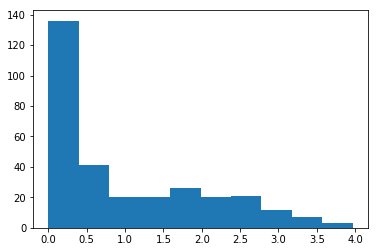

In [31]:
plt.hist( np.log(data_2['Axillary nodes']+1) ) 
plt.show()

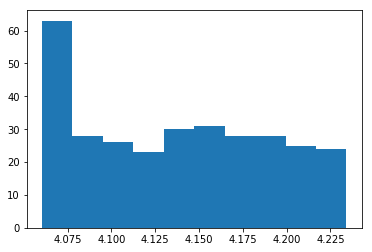

In [32]:
plt.hist( np.log(data_2['Year']) ) 
plt.show()

In [33]:
data_2['Axillary nodes'] = np.log(data_2['Axillary nodes']+1)
data_2['Year'] = np.log(data_2['Year'])

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

data_2 = poly.fit_transform(data_2[data_2.columns.difference(['Survival status'])])
data_2.shape

(306, 10)

In [35]:
data_2 = minmax_scale(data_2)

In [36]:
data_2 = pd.DataFrame(columns=poly.get_feature_names(), data=data_2)
data_2.shape

(306, 10)

In [37]:
data_2.head()

,1,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,0.0,0.000000,0.174583,0.566844,0.000000,0.098022,0.004467,0.030479,0.178070,0.561703
1,0.0,0.000000,0.349167,0.384026,0.000000,0.196045,0.000000,0.121917,0.353421,0.379074
2,0.0,0.000000,0.000000,0.656121,0.000000,0.000000,0.006649,0.000000,0.000000,0.651397
3,0.0,0.018868,0.276708,0.098434,0.010185,0.160540,0.012146,0.076567,0.276714,0.096576
4,0.0,0.018868,0.405370,0.656121,0.010185,0.235187,0.026228,0.164325,0.415007,0.651397


In [38]:
data_2.isna().sum().any()

False

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = {2:125, 1:225}, k_neighbors = 10, random_state=123)
X_res, y_res = sm.fit_sample(data_2,y)

print(X_res.shape)
print(y_res.shape)

(350, 10)
(350,)


In [40]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_res, y_res, random_state=123, test_size = 0.33)

<b>Logistic Regression after feature engineering:

In [41]:
LR2 = LogisticRegressionCV(cv=5, penalty='l1', n_jobs=4, solver='liblinear', max_iter=1000)
LR2.fit(X2_train, y2_train)

y2_tr_pred = LR2.predict(X2_train)
y2_ts_pred = LR2.predict(X2_test)

In [42]:
print('Accuracy scores:')
print('Train :',accuracy_score(y2_train, y2_tr_pred))
print('Test :',accuracy_score(y2_test, y2_ts_pred))

Accuracy scores:
Train : 0.7008547008547008
Test : 0.7068965517241379


In [43]:
print('On training data :')
print(classification_report(y2_train, y2_tr_pred))

On training data :
              precision    recall  f1-score   support

           1       0.72      0.88      0.79       151
           2       0.63      0.37      0.47        83

   micro avg       0.70      0.70      0.70       234
   macro avg       0.68      0.63      0.63       234
weighted avg       0.69      0.70      0.68       234



In [44]:
print('On test data :')
print(classification_report(y2_test, y2_ts_pred))

On test data :
              precision    recall  f1-score   support

           1       0.73      0.85      0.79        74
           2       0.63      0.45      0.53        42

   micro avg       0.71      0.71      0.71       116
   macro avg       0.68      0.65      0.66       116
weighted avg       0.70      0.71      0.69       116



Our Logistic regression with polynomial features (feature engineering) and improved class balance marginally performed better than an XGBoost model without feature engineering. Let us test it after Feature engineering.

<b>XGB after feature engineering:

In [45]:
from xgboost import XGBClassifier

XGB = XGBClassifier(max_depth=2, learning_rate=0.03, random_state=123, n_estimators=500, nthread = -1, booster='gbtree')

XGB.fit(X2_train, y2_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [46]:
# GBM.fit(X_train,y_train)

y2_tr_gbm = XGB.predict(X2_train)
y2_ts_gbm = XGB.predict(X2_test)

In [47]:
print('Accuracy scores:')
print('Train :',accuracy_score(y2_train, y2_tr_gbm))
print('Test :',accuracy_score(y2_test, y2_ts_gbm))

Accuracy scores:
Train : 0.8803418803418803
Test : 0.6724137931034483


In [48]:
print('On training data :')
print(classification_report(y2_train, y2_tr_gbm))

On training data :
              precision    recall  f1-score   support

           1       0.88      0.94      0.91       151
           2       0.88      0.77      0.82        83

   micro avg       0.88      0.88      0.88       234
   macro avg       0.88      0.86      0.87       234
weighted avg       0.88      0.88      0.88       234



In [49]:
print('On test data :')
print(classification_report(y2_test, y2_ts_gbm))

On test data :
              precision    recall  f1-score   support

           1       0.72      0.80      0.76        74
           2       0.56      0.45      0.50        42

   micro avg       0.67      0.67      0.67       116
   macro avg       0.64      0.62      0.63       116
weighted avg       0.66      0.67      0.66       116



There is no improvement in the performance of our model.

<b>======================================================================================================================================